In [169]:


import os
import os.path as op
import sys
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP, cross_val_multiscore, GeneralizingEstimator
from library import helpers, config



# Get SLURM job number:
# job_nr = int(float(sys.argv[1]))

old_log_level = mne.set_log_level('WARNING', return_old_level=True)



def get_epos(subID, part_epo, signaltype, condition, event_dict, picks_str=None):
    """Load a set of specified epochs.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    condition: str
        Experimental condition. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'
        
    Returns
    -------
    mne.Epochs
        Array of selected epochs.
    """
    
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + part_epo +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, part_epo, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    
    # pick channel selection:
    if (picks_str is not None) and (picks_str is not 'All'):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)

    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)


def get_sensordata(subID, part_epo, signaltype, conditions, event_dict, picks_str=None):
    """Load a set of specified epochs for classification.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    conditions: list
        List of experimental conditions. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'
        
    Returns
    -------
    X_epos: Epochs
        Array of selected epochs, sorted by class (starting with class '0').
    y: list
        Sorted list of labels.
    times_n: array, 1d
        Times of the samples within the single epoch.
    """
    
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   part_epo=part_epo,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict,
                                   picks_str=picks_str)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def decode(sub_list_str, conditions, event_dict, temp_gen=True, reps = 1, scoring = 'roc_auc', 
           min_freq=6, max_freq=26, n_freqs=10,
           shuffle_labels = False, save_scores = True, save_csp_patterns = True, 
           overwrite = False, part_epo = 'stimon', signaltype='collapsed', picks_str=None):
    """Apply CSP and LDA to perform binary classification from (the power) of epoched data.
    
    
    
    
    Original code from: 
    https://mne.tools/stable/auto_examples/decoding/plot_decoding_csp_timefreq.html#
    sphx-glr-auto-examples-decoding-plot-decoding-csp-timefreq-py

    
    Parameters
    ----------
    sub_list_str : list of str
        List of subject identifiers (eg, 'VME_S05')
    conditions: list
        List of experimental conditions that shall be compared/decoded. 
        Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict
    reps: int 
        Number of repetions for the CV procedure.
    scoring: str
        Scoring metric to be used; 'roc_auc' (default), 'accuracy', or 'balanced_accuracy'
    min_freq: float, int
        Lower bound of lowest freq band to be used (default: 6)
    max_freq: float, int
        Upper bound of highest freq band to be used (default: 26)
    n_freqs: 
        Number of freq bands that the interval between min_freq and max_freq is split into (default: 10)
    shuffle_labels: bool
        Shuffle the labels to produce a null distribution.
    save_scores: bool, optional
        Shall the decoding scores be written to disk? (default is True).
    save_patterns: bool, optional
        Shall the CSP patterns be written to disk? (default is True).
    overwrite : bool
        Overwrite existing folders (True) or append current datetime to foldername (False). (default is False)
    part_epo : str, optional
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon' (default is 'stimon').
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
                                                       (default is 'collapsed'.)
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'
        
    Returns
    -------
    tf_scores_list: list
        list of 2d arrays (freq x time) with the decoding scores per subject
    centered_w_times: list
        list with the times around which the decoding windows were centered.
    """
    
    contrast_str = '_vs_'.join(conditions)

    if temp_gen:
        gen_str = 'gen_temp'
    else:
        gen_str = ''
    
    cv_folds = 5
    n_components = 6
    reg = 0.4 # 'ledoit_wolf'
    
    csp = CSP(n_components=n_components, reg=reg, log=True, norm_trace=False, component_order='alternate')
    clf = make_pipeline(csp, LinearDiscriminantAnalysis())
    time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                     verbose=True)
    
    # Classification & time-frequency parameters
    tmin = -0.5 # -config.times_dict['cue_dur']
    tmax =  2.5  # config.times_dict['stim_dur'] + config.times_dict['retention_dur']
    n_cycles = None  # how many complete cycles: used to define window size
    w_size = 0.5
    w_overlap = 0.5 # how much shall the windows overlap [value in [0,1]; 0: no overlap, 1: full overlap]
    fmin = min_freq
    fmax = max_freq
#     n_freqs = n_freqs  # how many frequency bins to use

#     # Get datetime identifier for uniqure folder names (if not overwriting):
#     datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M')

#     # Assemble list of frequency range tuples
#     freqs = np.linspace(min_freq, max_freq, n_freqs + 1)  # assemble frequencies
#     freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples# Setup list of seeds for the repetitions:
    
    # Setup list of seeds for the repetitions:
    np.random.seed(seed=42)
    rep_seeds = np.random.choice(range(10 * reps), reps)
    

    if ((n_cycles is not None) and (w_size is None)): 
        # Infer window spacing from the max freq and number of cycles to avoid gaps
        window_spacing = (n_cycles / np.max(freqs) / 2.)
        centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
    elif (((w_size is not None)) and (n_cycles is None)): 
        assert 0 <= float(w_overlap or -1) < 1, f'Invalid value for w_overlap: {w_overlap}'
        step_size = w_size * (1 - w_overlap)
        centered_w_times = np.arange(tmin + (w_size / 2.), tmax - (w_size / 2) + 0.001, step_size)
    else: 
        raise ValueError(f'Invalid combination of values for w_size and n_cylces. Exactly one must be None.')

    n_windows = len(centered_w_times)

    tf_scores_list = list()
    tf_patterns_list = list()
    
    completed_subs = list()
    for subID in sub_list_str:
        part_epo = part_epo

        print(f'Running {subID}')

        X_epos, y, t = get_sensordata(subID, part_epo, signaltype, conditions, event_dict, picks_str)
        n_channels = len(X_epos.ch_names)
        # init scores
        tf_scores = np.zeros(n_windows)
        tf_x_arr = np.zeros((X_epos.get_data().shape[0], X_epos.get_data().shape[1], 
                             int(w_size * X_epos.info['sfreq'])+1, n_windows))
        tf_scores_tmp = np.zeros((reps, n_windows, n_windows))
        tf_patterns = np.zeros((n_components, n_channels, n_windows))


        if (w_size is None):
                # Infer window size based on the frequency being used (default behavuior is to use a fixed w_size)
            w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

        X_epos = X_epos.subtract_evoked()
            
        # Apply band-pass filter to isolate the specified frequencies
        X_epos_filter = X_epos.copy().filter(fmin, fmax, n_jobs=1, fir_design='firwin')

        # Roll covariance, csp and lda over time
        for t, w_time in enumerate(centered_w_times):

            # Center the min and max of the window
            w_tmin = w_time - w_size / 2.
            w_tmax = w_time + w_size / 2.

            # Crop data into time-window of interest
            X = X_epos_filter.copy().crop(w_tmin, w_tmax).get_data()
            if X.shape[-1] < int(w_size * X_epos.info['sfreq'])+1:
                diff = (int(w_size * X_epos.info['sfreq'])+1) - X.shape[-1]
                X = np.pad(X,[(0,0), (0,0), (0, diff)], 'constant', constant_values=0.5)
            tf_x_arr[:,:,:,t] = X

        # Run repeated CV to estimate decoding score:
        for rep, rand_state in enumerate(rep_seeds):
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rand_state)
            
            # Save mean scores over folds for each frequency and time window for this repetition
            
            tf_scores_tmp[rep, :, :] = np.mean(cross_val_multiscore(estimator=time_gen, 
                                                                 X=tf_x_arr[:,:,:,:], y=y,
                                                                 cv=cv,
                                                                 n_jobs=-2), 
                                             axis=0)
        tf_scores_list.append(tf_scores_tmp)



        # save info:
        if (save_scores or save_csp_patterns):
            completed_subs.append(subID)
            info_dict = {'subs': completed_subs,
                         'tmin': tmin, 
                         'tmax': tmax, 
                         'n_cycles': n_cycles, 
                         'w_size': w_size,
                         'w_overlap': w_overlap,
                         'min_freq': min_freq, 
                         'max_freq': max_freq,
                         'n_freqs': n_freqs,
                         'cv_folds': cv_folds, 
                         'reps': reps,
                         'scoring': scoring}
            
#             if not isinstance(sub_list_str, list):
#                 sub_list_str = [sub_list_str]
            
#             if len(sub_list_str) > 1:
#                  sub_folder = '-'.join([sub_list_str[0], sub_list_str[-1]])
#             else:
#                  sub_folder = sub_list_str[0]

            sub_folder = subID
            
            if shuffle_labels:
                shuf_labs = 'labels_shuffled'
            else: 
                shuf_labs = ''
                
            if reg is not None:
                if isinstance(reg, float):
                    reg_str = 'shrinkage'+str(reg)
                else: 
                    reg_str = reg
            else:
                reg_str = ''
                
            if picks_str is not None:
                picks_str_folder = picks_str
            else:
                picks_str_folder = ''
            
            fpath = op.join(config.path_decod_tfr, part_epo, signaltype, 
                            contrast_str, gen_str, scoring, reg_str, picks_str_folder, 
                            shuf_labs, sub_folder)
            if (op.exists(fpath) and not overwrite):
                path_save = op.join(config.path_decod_tfr, part_epo, signaltype, 
                                    contrast_str + datetime_str, gen_str, scoring, 
                                    reg_str, picks_str_folder, shuf_labs, 
                                   sub_folder + datetime_str)
            else:
                path_save = fpath
            helpers.chkmk_dir(path_save)
            fname = op.join(path_save, 'info.json')
            with open(fname, 'w+') as outfile:  
                json.dump(info_dict, outfile)
        
        if save_csp_patterns:
            sub_patterns_ = np.asarray(tf_patterns_list)
            fpath = op.join(path_save, 'patterns')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, 'patterns_per_sub.npy')
            np.save(fname, sub_patterns_)
            np.save(fname[:-4] + '__times' + '.npy', centered_w_times)
            del(fpath, fname)
        
        
        if save_scores:
            sub_scores_ = np.asarray(tf_scores_list)
            fpath = op.join(path_save, 'scores')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, 'scores_per_sub.npy')
            np.save(fname, sub_scores_)
            np.save(fname[:-4] + '__times' + '.npy', centered_w_times)
            del(fpath, fname)

    return tf_scores_list, centered_w_times



In [170]:
job_nr = 0

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]
# sub_list_str = ['VME_S01', 'VME_S02']
# sub_list_str = [sub_list_str[job_nr]]

cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}


In [ ]:
scores, times = decode(sub_list_str, ['LoadLow', 'LoadHigh'], config.event_dict, 
                       temp_gen = True, reps=20, scoring='roc_auc', 
                       shuffle_labels=False, overwrite=True, picks_str='All', min_freq=8, max_freq=14, n_freqs=1)


Running VME_S01


<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:131: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
<ipython-input-169-c6e47752a8c2>:289: RuntimeWarning: tmax is not in epochs time inte

Running VME_S02


<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:131: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
<ipython-input-169-c6e47752a8c2>:289: RuntimeWarning: tmax is not in epochs time inte

Running VME_S03


<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:70: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epos = mne.read_epochs(fname, verbose=False)
<ipython-input-169-c6e47752a8c2>:131: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
<ipython-input-169-c6e47752a8c2>:289: RuntimeWarning: tmax is not in epochs time inte

In [138]:
rs = np.asarray(scores)
# mean across reps:
rs = np.mean(rs, axis=1)
# mean across subjects
rs = np.mean(rs, axis=0)

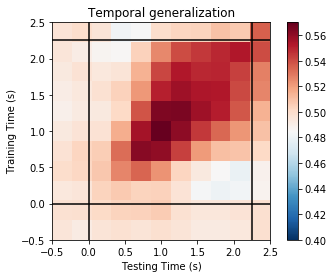

In [168]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(rs, interpolation=None, origin='lower', cmap='RdBu_r',
               extent=[times[0]-0.25,times[-1]+0.25,times[0]-0.25,times[-1]+0.25,],
               vmin=0.4, vmax=0.57)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
ax.axvline(2.25, color='k')
ax.axhline(2.25, color='k')
plt.colorbar(im, ax=ax)

In [161]:
times

array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
        2.  ,  2.25])